In [39]:
# Start writing code here...

In [40]:
!pip install nltk
!pip install bert-tensorflow
!pip install transformers
!pip install seaborn
!pip install -U sentence-transformers
import nltk
nltk.download('punkt')
nltk.download('stopwords')


You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
Requirement already up-to-date: sentence-transformers in /opt/venv/lib/python3.7/site-packages (0.3.3)
You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
# Insert code here.
import pandas as pd
import numpy as np
import random
import re
import time
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, neighbors
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
sent_encoder = SentenceTransformer('bert-base-nli-mean-tokens')


In [42]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [43]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Aug 21 07:08:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    31W /  70W |   6268MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [44]:
DATASET_PATH = '/home/jovyan/work/Hate-Speech-Detection/hasoc_2020_en_train.csv'

In [45]:
df = pd.read_csv(DATASET_PATH)
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 3,794



,tweet_id,text,task1,task2,ID
298,1126739484907720704,Best. (Obvs I can say this because my kid is a...,HOF,PRFN,hasoc_2020_en_364
3077,1130035259930628096,"That was a rather odd question. However, who w...",NOT,NONE,hasoc_2020_en_80
1361,1130204877563412480,RT @bffnamu: hoseok: yeah i support mens right...,HOF,PRFN,hasoc_2020_en_5091
3133,1126938718521253889,Bullet to the head fucking sick fuck,HOF,PRFN,hasoc_2020_en_4525
2415,1127023896455204864,RT @nysohollywood: Don't ever stop Being a sol...,HOF,HATE,hasoc_2020_en_1282
2298,1123686459406467074,Holy mother of glob..... 😳 https://t.co/Gsqi0d...,NOT,NONE,hasoc_2020_en_4274
402,1123507828168151040,RT @ApostateRidvan: Ex-Muslim: I left Islam.\n...,NOT,NONE,hasoc_2020_en_5232
321,1126879763388301312,I think I’m boutta fw Waffle House,NOT,NONE,hasoc_2020_en_2575
2623,1126833701520695296,Little girl you know you dont have to expose b...,HOF,PRFN,hasoc_2020_en_1458
478,1126851430881611776,RT @jensrina: this shit happens way too often ...,HOF,PRFN,hasoc_2020_en_2864


In [46]:
LE = LabelEncoder()
df['task1'] = LE.fit_transform(df['task1'])
df['task2'] = LE.fit_transform(df['task2'])
df.head()

,tweet_id,text,task1,task2,ID
0,1123757263427186690,"hate wen females hit ah nigga with tht bro 😂😂,...",0,3,hasoc_2020_en_2574
1,1123733301397733380,RT @airjunebug: When you're from the Bay but y...,0,3,hasoc_2020_en_3627
2,1123734094108659712,RT @DonaldJTrumpJr: Dear Democrats: The Americ...,1,1,hasoc_2020_en_3108
3,1126951188170199049,RT @SheLoveTimothy: He ain’t on drugs he just ...,1,3,hasoc_2020_en_3986
4,1126863510447710208,RT @TavianJordan: Summer ‘19 I’m coming for yo...,1,1,hasoc_2020_en_5152


In [47]:
df

,tweet_id,text,task1,task2,ID
0,1123757263427186690,"hate wen females hit ah nigga with tht bro 😂😂,...",0,3,hasoc_2020_en_2574
1,1123733301397733380,RT @airjunebug: When you're from the Bay but y...,0,3,hasoc_2020_en_3627
2,1123734094108659712,RT @DonaldJTrumpJr: Dear Democrats: The Americ...,1,1,hasoc_2020_en_3108
3,1126951188170199049,RT @SheLoveTimothy: He ain’t on drugs he just ...,1,3,hasoc_2020_en_3986
4,1126863510447710208,RT @TavianJordan: Summer ‘19 I’m coming for yo...,1,1,hasoc_2020_en_5152
...,...,...,...,...,...
3789,1126887103437123584,RT @FilthyArt_: TONIGHT TONIGHT TONIGHT \n\nCa...,1,1,hasoc_2020_en_109
3790,1126825614906937344,RT @abbn0rmal_: Eat my ass,0,3,hasoc_2020_en_2345
3791,1126880392550731776,RT @FlyTPA: BREAKING NEWS: TPA is about to get...,1,1,hasoc_2020_en_1039
3792,1130290906932891648,RT @StarrThaRapper: It’s been a hr FUCK THAT G...,0,3,hasoc_2020_en_2817


In [48]:
def count_words(text):
    return len(text.split())

In [49]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['text'], df['task1'], test_size=0.2, stratify=df['task1'])

In [50]:
df.text.apply(count_words).max()

57

In [51]:
MAX_LENGTH = 57
posts = train_x.values
categories = train_y.values

In [52]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

In [53]:
print('Original: ', posts[0])
print('Token IDs:', input_ids[0])

Original:  @SubDeliveryZone @_EDET_ It pains me so much that this idiot, nonentity, vagabond, asshole, piece of shit is from m… https://t.co/XYbodjVKv9
Token IDs: tensor([  101,  1030,  4942,  9247, 16402,  2100, 15975,  1030,  1035,  3968,
         3388,  1035,  2009, 20398,  2033,  2061,  2172,  2008,  2023, 10041,
         1010,  3904, 16778,  3723,  1010, 12436,  3654, 11735,  2094,  1010,
        22052,  1010,  3538,  1997,  4485,  2003,  2013,  1049,  1529, 16770,
         1024,  1013,  1013,  1056,  1012,  2522,  1013,  1060,  2100,  5092,
         2094,  3501,  2615,  2243,  2615,  2683,   102])


In [54]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.875 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


2,655 training samples
  380 validation samples


In [95]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [96]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [97]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [98]:
optimizer = AdamW(model.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

In [99]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [100]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [101]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [114]:
seed_val = 42
torch.cuda.empty_cache()
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 1 ========
Training...
  Batch    40  of    166.    Elapsed: 0:00:08.
  Batch    80  of    166.    Elapsed: 0:00:16.
  Batch   120  of    166.    Elapsed: 0:00:24.
  Batch   160  of    166.    Elapsed: 0:00:32.

  Average training loss: 0.25
  Training epcoh took: 0:00:33

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.37
  Validation took: 0:00:01

Training complete!
Total training took 0:00:34 (h:mm:ss)


In [115]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.25,0.37,0.86,0:00:33,0:00:01


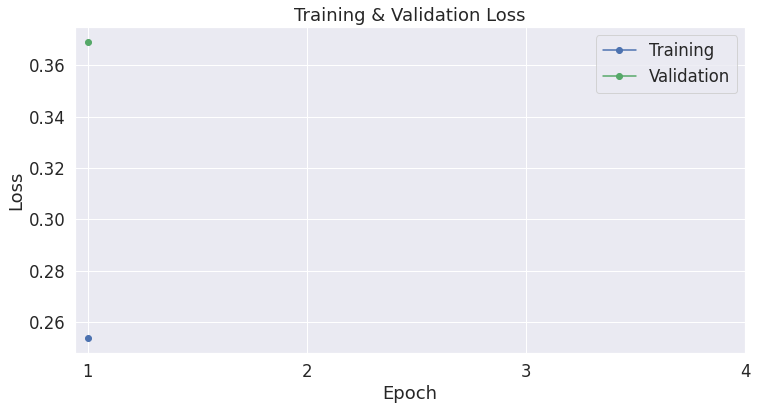

In [116]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [127]:
posts = valid_x.values
categories = valid_y.values

In [128]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [129]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 759 test sentences...
    DONE.


In [130]:
print(predictions[0],true_labels[0])

[[ 0.82508224  2.94151    -2.4146013  -2.532692  ]
 [ 0.47654933  2.683509   -1.8459239  -1.9341694 ]
 [ 3.315425   -0.21532485 -2.5788836  -2.3548787 ]
 [ 1.0752585   2.7221966  -2.5618703  -2.719432  ]
 [ 1.2473569   2.5893815  -2.6499958  -2.8032107 ]
 [ 1.0754917   2.8616848  -2.5640492  -2.7016664 ]
 [ 0.84355515  2.8191223  -2.3605673  -2.5583594 ]
 [ 3.355738   -0.9292546  -2.286062   -2.0439198 ]
 [ 3.3472862  -0.6728398  -2.4542282  -2.185092  ]
 [ 1.5165422   2.52484    -2.9374576  -2.8788083 ]
 [ 1.1470115   2.859355   -2.5820014  -2.6111279 ]
 [ 0.9747186   2.747046   -2.3645108  -2.5348969 ]
 [ 3.2146878  -0.71943367 -2.2024915  -1.9513032 ]
 [ 3.3695228  -0.40303448 -2.4956977  -2.2137654 ]
 [ 3.1965797   0.08630943 -2.6975     -2.4751804 ]
 [ 0.70683885  2.968207   -2.3919835  -2.5361562 ]] [1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1]


In [131]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
predicts = []
accurate = 0
total_len = 0
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    predicts.append(pred_labels_i)
    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)

    matthews_set.append(matthews)
    for j in range(len(true_labels[i])):
        if true_labels[i][j] == pred_labels_i[j]:
            accurate+=1
        total_len+=1
print("Accuracy:",accurate/total_len)

Calculating Matthews Corr. Coef. for each batch...
Accuracy: 0.8814229249011858


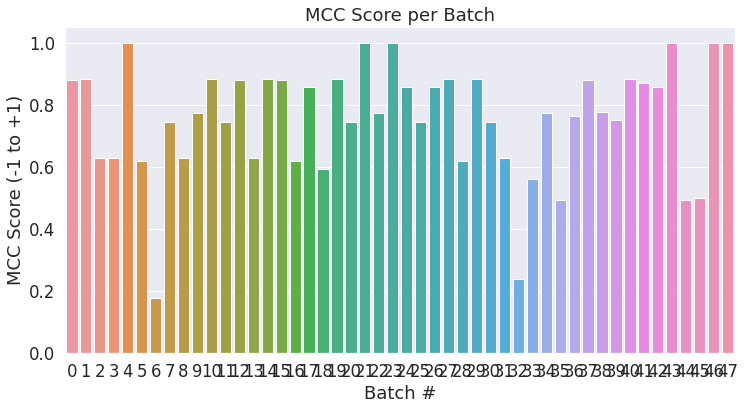

In [132]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()


In [133]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.763


In [134]:
accurate = 0
for (i,j) in zip(flat_predictions, flat_true_labels):
    if i==j:
        accurate += 1
accurate/len(flat_predictions)

0.8814229249011858

In [135]:
from sklearn.metrics import f1_score
f1_score(flat_true_labels, flat_predictions, average='macro')

0.8813765941485372

In [74]:
# MODEL_PATH = '/home/jovyan/work/Hate-Speech-Detection/model_english_epoch_'+str(epochs)

In [75]:
# torch.save(model, MODEL_PATH)

In [126]:
model = torch.load('/home/jovyan/work/Hate-Speech-Detection/models/model_epoch_1')